# EDA

**Исходные данные:** .tif спутниковый снимок, .tif маска с геоданными.

**Цель:** обучить модель Unet для сегментации леса на спутниковых снимках

**План выполнения EDA:**
1. Визуализация изображений
2. Получение основной информации о снимках. Размер, геоданные, количество каналов и так далее
3. Разделение снимка и маски на патчи определенного размера. Их визуализация
4. Формирование датасетов train, val, test, создание соответствующих папок

Количество объектов (деревьев):
* *зеленые*: 2762
* *желтые*: 1087
* *красные*: 566
* *всего*: 4415

Цвета на маске:

* 55,96,255 -- красный
* 55,250,250 -- желтый
* 83,179,36 -- зеленый

## Импорт необходимых библиотек

In [2]:
import rasterio
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import cv2

## Функции

### Создание директорий для данных

In [3]:
def create_dirs(base_dir: str) -> None:
    """
    Создает директории под train, test, val выборки, в которых будут храниться патчи

    :param
        base_dir: Базовая директория для патчей
    :return:
        None: ничего
    """
    os.makedirs(base_dir, exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'train/images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'train/labels'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'test/images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'test/labels'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'val/images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'val/labels'), exist_ok=True)

### Получение основной информации об изображении

In [4]:
def get_info(path_to_image: str) -> None:
    """
    Выводит основную информацию об изображении

    :return:
        None: ничего
    """
    with rasterio.open(path_to_image) as src:
        print("✅ Основная информация:")
        print(f"- Ширина: {src.width}")
        print(f"- Высота: {src.height}")
        print(f"- Количество пикселей: {src.width * src.height}")
        print(f"- Количество каналов: {src.count}")
        print(f"- Тип данных: {src.dtypes}")
        print(f"- CRS (система координат): {src.crs}")
        print(f"- Transform (геопривязка): {src.transform}")
        print()

        print("🧾 Полные метаданные (src.meta):")
        print(src.meta)

### Получение rgb разложение изображения

In [5]:
def get_image_array(path_to_image: str) -> np.ndarray:
    """
    Получаем изображение в виде матрицы формы (height, width, channels)

    :return:
        np.ndarray: Матрица
    """
    return np.array(Image.open(path_to_image))

### Визуализация изображения

In [6]:
def visualization_image(path_to_image: str) -> None:
    """
    Визуализируем изображение с помощью matplotlib

    :return:
        None: ничего
    """
    rgb = get_image_array(path_to_image)

    plt.figure(figsize=(10, 15))
    plt.imshow(rgb)
    plt.tight_layout()
    plt.axis('off')
    plt.show()

### Подсчет количества меток определенного цвета на маске

In [7]:
def count_pixels_by_color(path_to_image: str) -> dict:
    """
    Считаем количество пикселей разных цветов на маске

    :return:
        dict: Словарь с количеством пикселей по цветам на маске
    """
    image = cv2.imread(path_to_image)

    color_counts = {
        'red': 0,
        'yellow': 0,
        'green': 0,
        'black': 0
    }

    # Определим цвета в BGR (OpenCV использует BGR)
    colors_bgr = {
        'red':    ([55, 96, 255], [55, 96, 255]),
        'yellow': ([55, 250, 250], [55, 250, 250]),
        'green':  ([83, 179, 36], [83, 179, 36]),
        'black':  ([0, 0, 0], [0, 0, 0])
    }

    for color, (lower, upper) in colors_bgr.items():
        mask = cv2.inRange(image, np.array(lower), np.array(upper))
        count = cv2.countNonZero(mask)
        color_counts[color] = count

    return color_counts

### Нарезание изображения на патчи

In [8]:
def slice_image(path_to_image: str, size: int) -> list:
    """
    Нарезает исходное изображение на патчи со стороной размера size

    :param
        size: размер стороны патча
    :return:
        None: ничего
    """
    image = get_image_array(path_to_image)

    patches = []

    height, width, channels = image.shape
    h_steps = (height + size - 1) // size
    w_steps = (width + size - 1) // size

    for h in range(h_steps):
        for w in range(w_steps):

            start_h = h * size
            start_w = w * size
            end_h = min(start_h + size, height)
            end_w = min(start_w + size, width)


            patch = image[start_h:end_h, start_w:end_w, :]


            if patch.shape[0] < size or patch.shape[1] < size:
                padded_patch = np.zeros((size, size, channels), dtype=patch.dtype)
                padded_patch[:patch.shape[0], :patch.shape[1], :] = patch
                patch = padded_patch

            patches.append(patch)

    return patches

### Сохранение патчей в виде .png изображений

In [9]:
def save_patches(patches: list, labels: list, split_type: str, base_dir: str, prefix: str) -> None:
    for i, (patch, label) in enumerate(zip(patches, labels)):
        img = Image.fromarray(patch)
        img.save(os.path.join(base_dir, f'{split_type}/images/{prefix}_{i}.png'))

        label_img = Image.fromarray(label)
        label_img.save(os.path.join(base_dir, f'{split_type}/labels/{prefix}_{i}.png'))

## Исходный спутниковый снимок

### Путь до изображения

In [10]:
path_to_orig = 'data/satellite_image.tif'

### Получение основной информации

In [11]:
get_info(path_to_orig)

✅ Основная информация:
- Ширина: 5930
- Высота: 10759
- Количество пикселей: 63800870
- Количество каналов: 3
- Тип данных: ('uint8', 'uint8', 'uint8')
- CRS (система координат): EPSG:32640
- Transform (геопривязка): | 0.05, 0.00, 468337.42|
| 0.00,-0.05, 6464039.86|
| 0.00, 0.00, 1.00|

🧾 Полные метаданные (src.meta):
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5930, 'height': 10759, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 40N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northi

### Визуализация

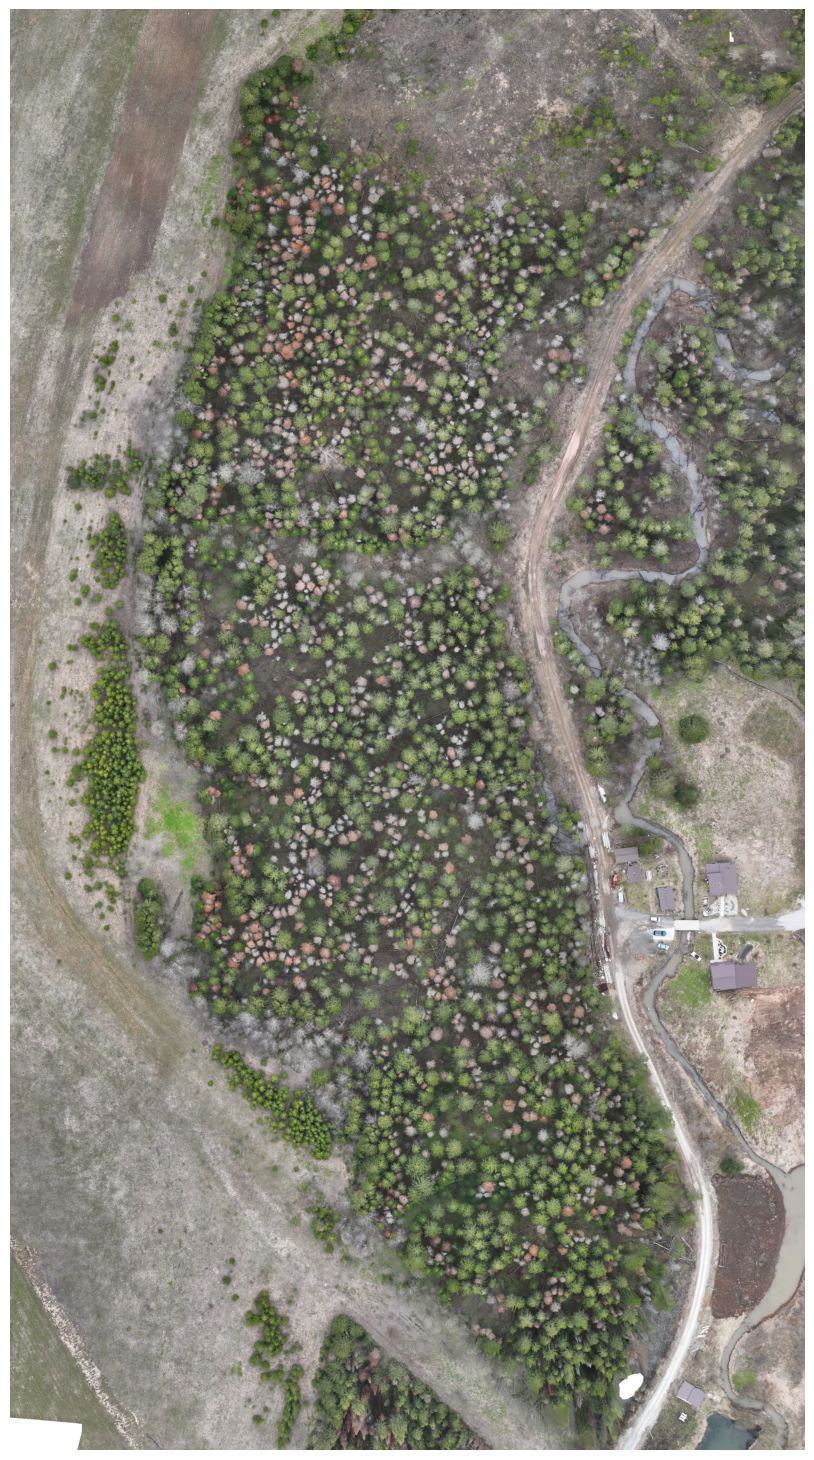

In [12]:
visualization_image(path_to_orig)

## Маска

### Путь до изображения

In [13]:
path_to_mask = 'data/mask.tif'

### Получение основной информации

In [14]:
get_info(path_to_mask)

✅ Основная информация:
- Ширина: 5930
- Высота: 10759
- Количество пикселей: 63800870
- Количество каналов: 3
- Тип данных: ('uint8', 'uint8', 'uint8')
- CRS (система координат): EPSG:32640
- Transform (геопривязка): | 0.05, 0.00, 468337.42|
| 0.00,-0.05, 6464039.86|
| 0.00, 0.00, 1.00|

🧾 Полные метаданные (src.meta):
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5930, 'height': 10759, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 40N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",57],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northi

### Визуализация

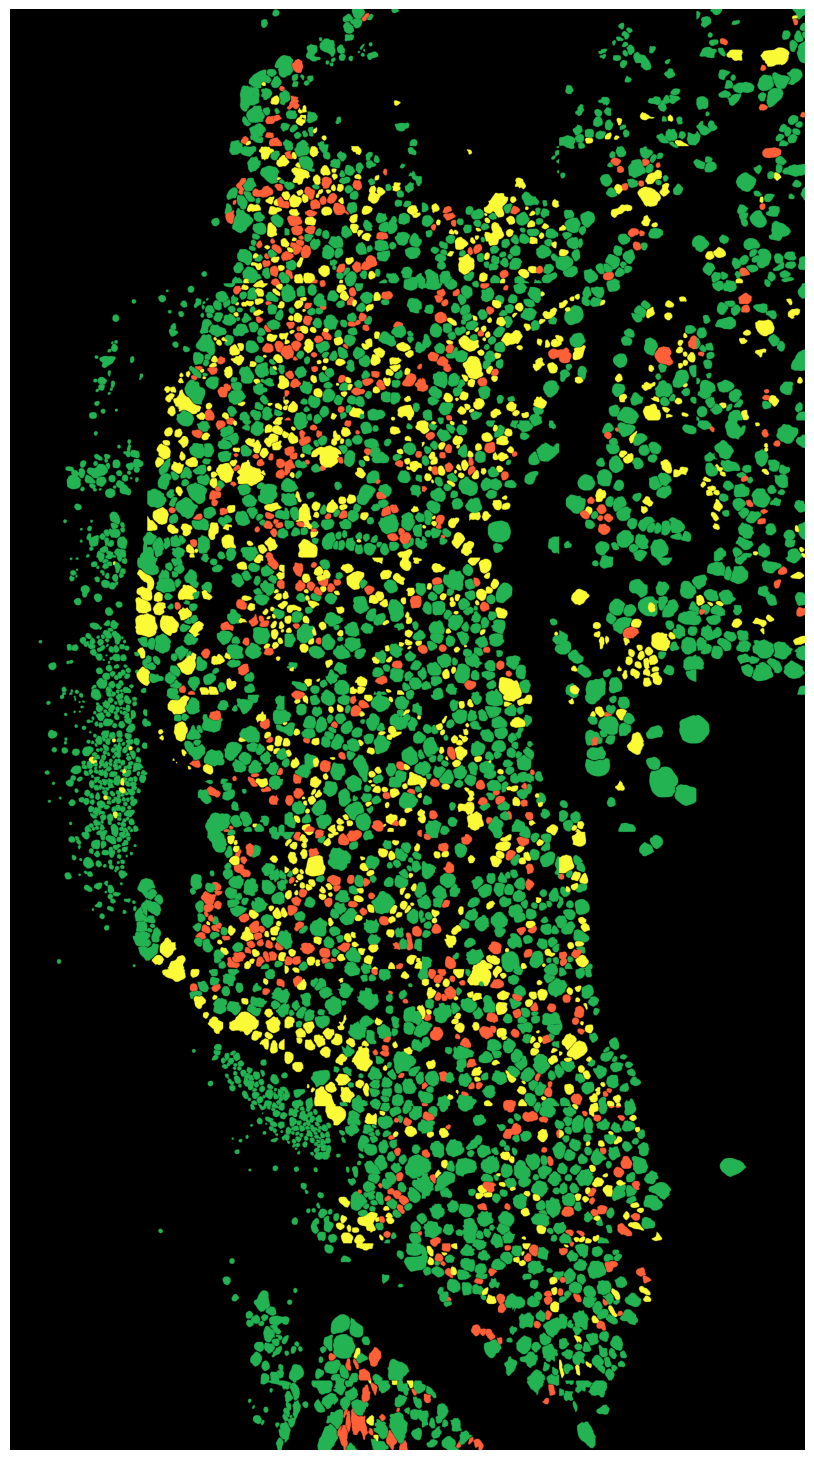

In [15]:
visualization_image(path_to_mask)

### Подсчет пикселей

In [16]:
count_pixels_by_color(path_to_mask)

{'red': 1702202, 'yellow': 3290532, 'green': 11578458, 'black': 47229678}

## Разделение изображений на патчи и сохранение в папки

### Создание директорий

In [ ]:
create_dirs('data/')

### Разделение изображений на патчи

In [ ]:
patches_orig = slice_image(path_to_orig, 256)
patches_mask = slice_image(path_to_mask, 256)

In [19]:
print(f"- Количество патчей размера 256*256: {len(patches_orig)}")

- Количество патчей размера 256*256: 1032


### Разделение выборки на train, val, test

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(patches_orig, patches_mask, test_size=0.2, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.50, random_state=42)

In [22]:
print(f"- Размер train выборки: {len(train_images)}")
print(f"- Размер val выборки: {len(val_images)}")
print(f"- Размер test выборки: {len(test_images)}")

- Размер train выборки: 825
- Размер val выборки: 103
- Размер test выборки: 104


### Сохранение патчей в папках

In [17]:
save_patches(train_images, train_labels, 'train', 'data/', 'patch')
save_patches(val_images, val_labels, 'val', 'data/', 'patch')
save_patches(test_images, test_labels, 'test', 'data/', 'patch')

TODO: Дописать для двух изображений. Исходные изображения не добавлять в репозиторий, а положить на яндекс диск и сделать ссылку. README.md для запуска

## Формирование датасета

### Импорт библиотек

In [1]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch

### Класс Dataset

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_paths = sorted(os.listdir(image_dir))
        self.mask_paths = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_paths[idx])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0
        image = np.transpose(image, (2, 0, 1))

        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = mask.astype(np.float32) / 255.0
        mask = np.transpose(mask, (2, 0, 1))

        if self.transform:
            image = self.transform(image)

        mask = torch.tensor(mask, dtype=torch.float32)
        image = torch.tensor(image, dtype=torch.float32)

        return image, mask

### Создание датасетов для train, val, test

In [4]:
train_dataset = SegmentationDataset('data/train/images', 'data/train/labels')
val_dataset = SegmentationDataset('data/val/images', 'data/val/labels')
test_dataset = SegmentationDataset('data/test/images', 'data/test/labels')

In [5]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

### Создание DataLoader для train, val, test

In [6]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

### Визуализация патча с маской из определенного датасета

In [13]:
def visualize_images_and_masks(dataset, start_image=0, num_images=10):
    plt.figure(figsize=(20, num_images * 3))

    for i in range(start_image, start_image + num_images):
        image, mask = dataset[i]

        if isinstance(image, torch.Tensor):
            image = image.numpy()
        if isinstance(mask, torch.Tensor):
            mask = mask.numpy()

        if image.ndim == 3 and image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))
        if mask.ndim == 3 and mask.shape[0] == 3:
            mask = np.transpose(mask, (1, 2, 0))

        plt.subplot(num_images, 2, (i-start_image)*2 + 1)
        plt.imshow(image)
        plt.title(f"Image {i+1}")
        plt.axis("off")


        plt.subplot(num_images, 2, (i-start_image)*2 + 2)
        plt.imshow(mask)
        plt.title(f"Mask {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

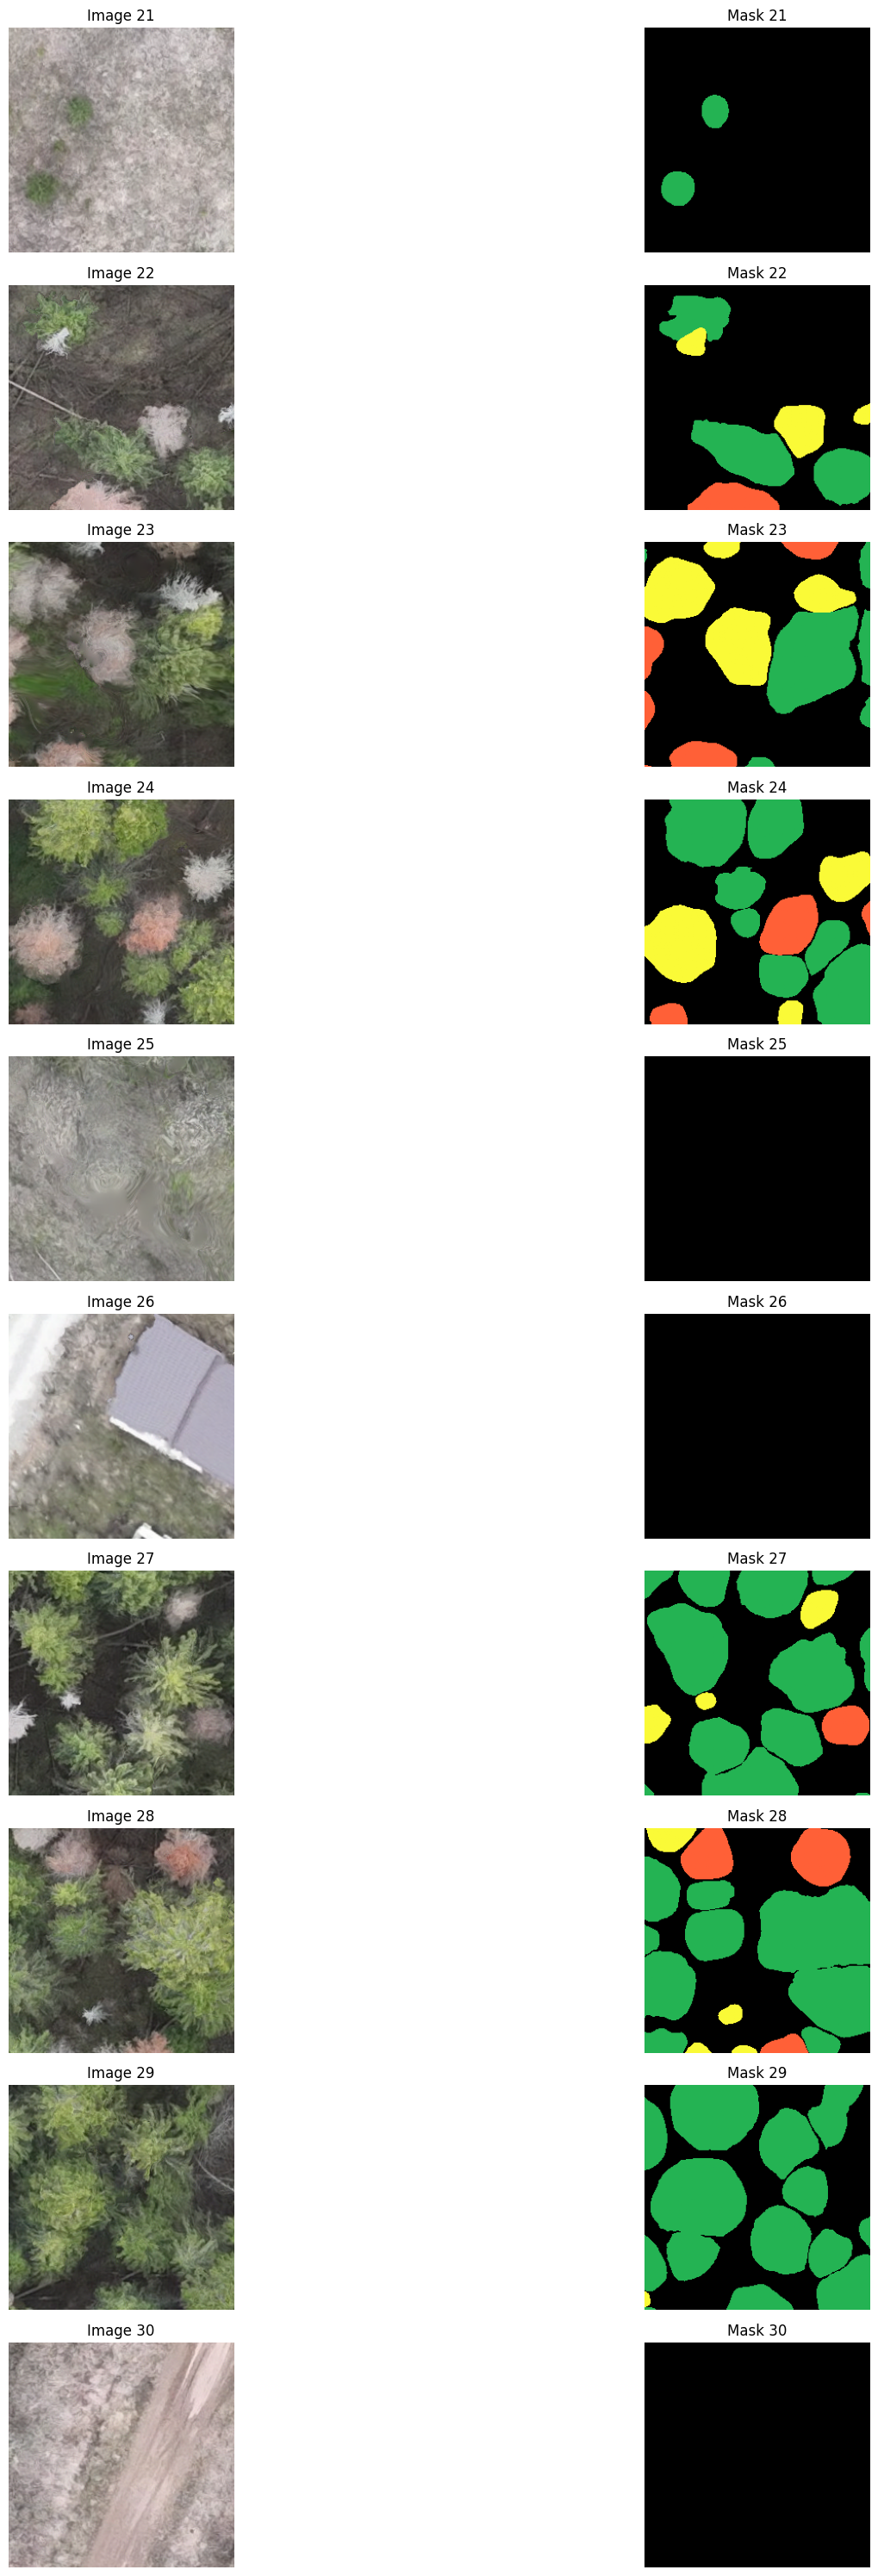

In [14]:
visualize_images_and_masks(train_dataset, start_image=20, num_images=10)

## Создание модели

### Импорт библиотек

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

### Модель

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip_features):
        x = self.upconv(x)
        x = torch.cat((x, skip_features), dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = EncoderBlock(3, 32)
        self.encoder2 = EncoderBlock(32, 64)
        self.encoder3 = EncoderBlock(64, 128)
        self.encoder4 = EncoderBlock(128, 256)

        self.bottleneck = ConvBlock(256, 512)

        self.decoder1 = DecoderBlock(512, 256)
        self.decoder2 = DecoderBlock(256, 128)
        self.decoder3 = DecoderBlock(128, 64)
        self.decoder4 = DecoderBlock(64, 32)

        self.output_conv = nn.Conv2d(32, 3, kernel_size=1)

    def forward(self, x):

        s1, p1 = self.encoder1(x)
        s2, p2 = self.encoder2(p1)
        s3, p3 = self.encoder3(p2)
        s4, p4 = self.encoder4(p3)


        b1 = self.bottleneck(p4)


        d1 = self.decoder1(b1, s4)
        d2 = self.decoder2(d1, s3)
        d3 = self.decoder3(d2, s2)
        d4 = self.decoder4(d3, s1)


        outputs = torch.softmax(self.output_conv(d4), dim=1)
        return outputs

### Вывод архитектуры модели

In [9]:
model = UNet()
print(model)

UNet(
  (encoder1): EncoderBlock(
    (conv): ConvBlock(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): EncoderBlock(
    (conv): ConvBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (

### Проверка, что CUDA доступна

In [10]:
print(torch.version.cuda)

11.8


In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Device: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPU")

CUDA is available. Device: NVIDIA GeForce GTX 980


### Обучение модели

In [12]:
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for images, masks in tqdm(dataloader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)

            loss = criterion(outputs, masks)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [14]:
EPOCHS = 10
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f"[INFO] Эпоха: {epoch + 1}/{EPOCHS}")

    train_loss = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

[INFO] Эпоха: 1/10


100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Train Loss: 0.4635, Validation Loss: 0.4626
[INFO] Эпоха: 2/10


100%|██████████| 13/13 [00:01<00:00, 10.80it/s]


Train Loss: 0.4616, Validation Loss: 0.4618
[INFO] Эпоха: 3/10


100%|██████████| 13/13 [00:01<00:00, 10.71it/s]


Train Loss: 0.4594, Validation Loss: 0.4605
[INFO] Эпоха: 4/10


100%|██████████| 13/13 [00:01<00:00, 10.55it/s]


Train Loss: 0.4588, Validation Loss: 0.4578
[INFO] Эпоха: 5/10


100%|██████████| 13/13 [00:01<00:00, 10.06it/s]


Train Loss: 0.4586, Validation Loss: 0.4559
[INFO] Эпоха: 6/10


100%|██████████| 13/13 [00:01<00:00, 10.71it/s]


Train Loss: 0.4584, Validation Loss: 0.4622
[INFO] Эпоха: 7/10


100%|██████████| 13/13 [00:01<00:00, 10.63it/s]


Train Loss: 0.4588, Validation Loss: 0.4567
[INFO] Эпоха: 8/10


100%|██████████| 13/13 [00:01<00:00, 10.22it/s]


Train Loss: 0.4594, Validation Loss: 0.4575
[INFO] Эпоха: 9/10


100%|██████████| 13/13 [00:01<00:00, 10.57it/s]


Train Loss: 0.4581, Validation Loss: 0.4549
[INFO] Эпоха: 10/10


100%|██████████| 13/13 [00:01<00:00, 10.32it/s]

Train Loss: 0.4575, Validation Loss: 0.4634


In [18]:
torch.save(model, "models/unet61")

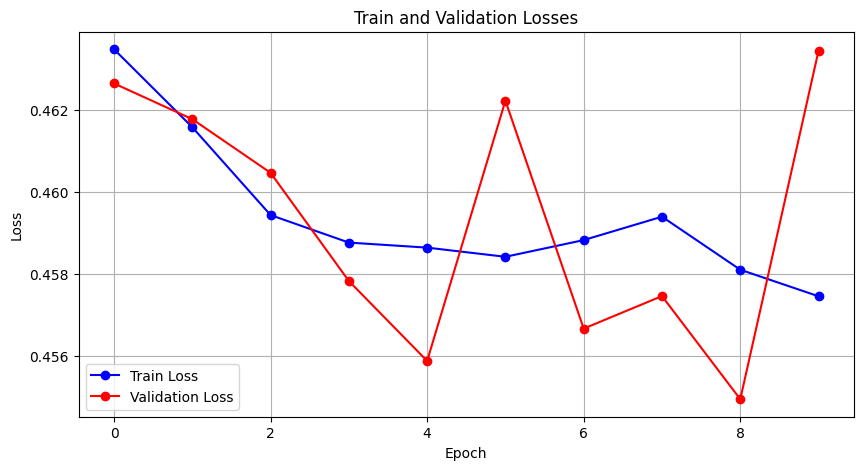

In [16]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', color='blue', marker='o')
    plt.plot(val_losses, label='Validation Loss', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

In [17]:
def test(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            preds = (outputs > 0.5).float()

            all_preds.append(preds.cpu().numpy())
            all_labels.append(masks.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    all_preds = all_preds.flatten()
    all_labels = all_labels.flatten()

    avg_loss = test_loss / len(dataloader)
    return avg_loss


test_loss = test(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.4690


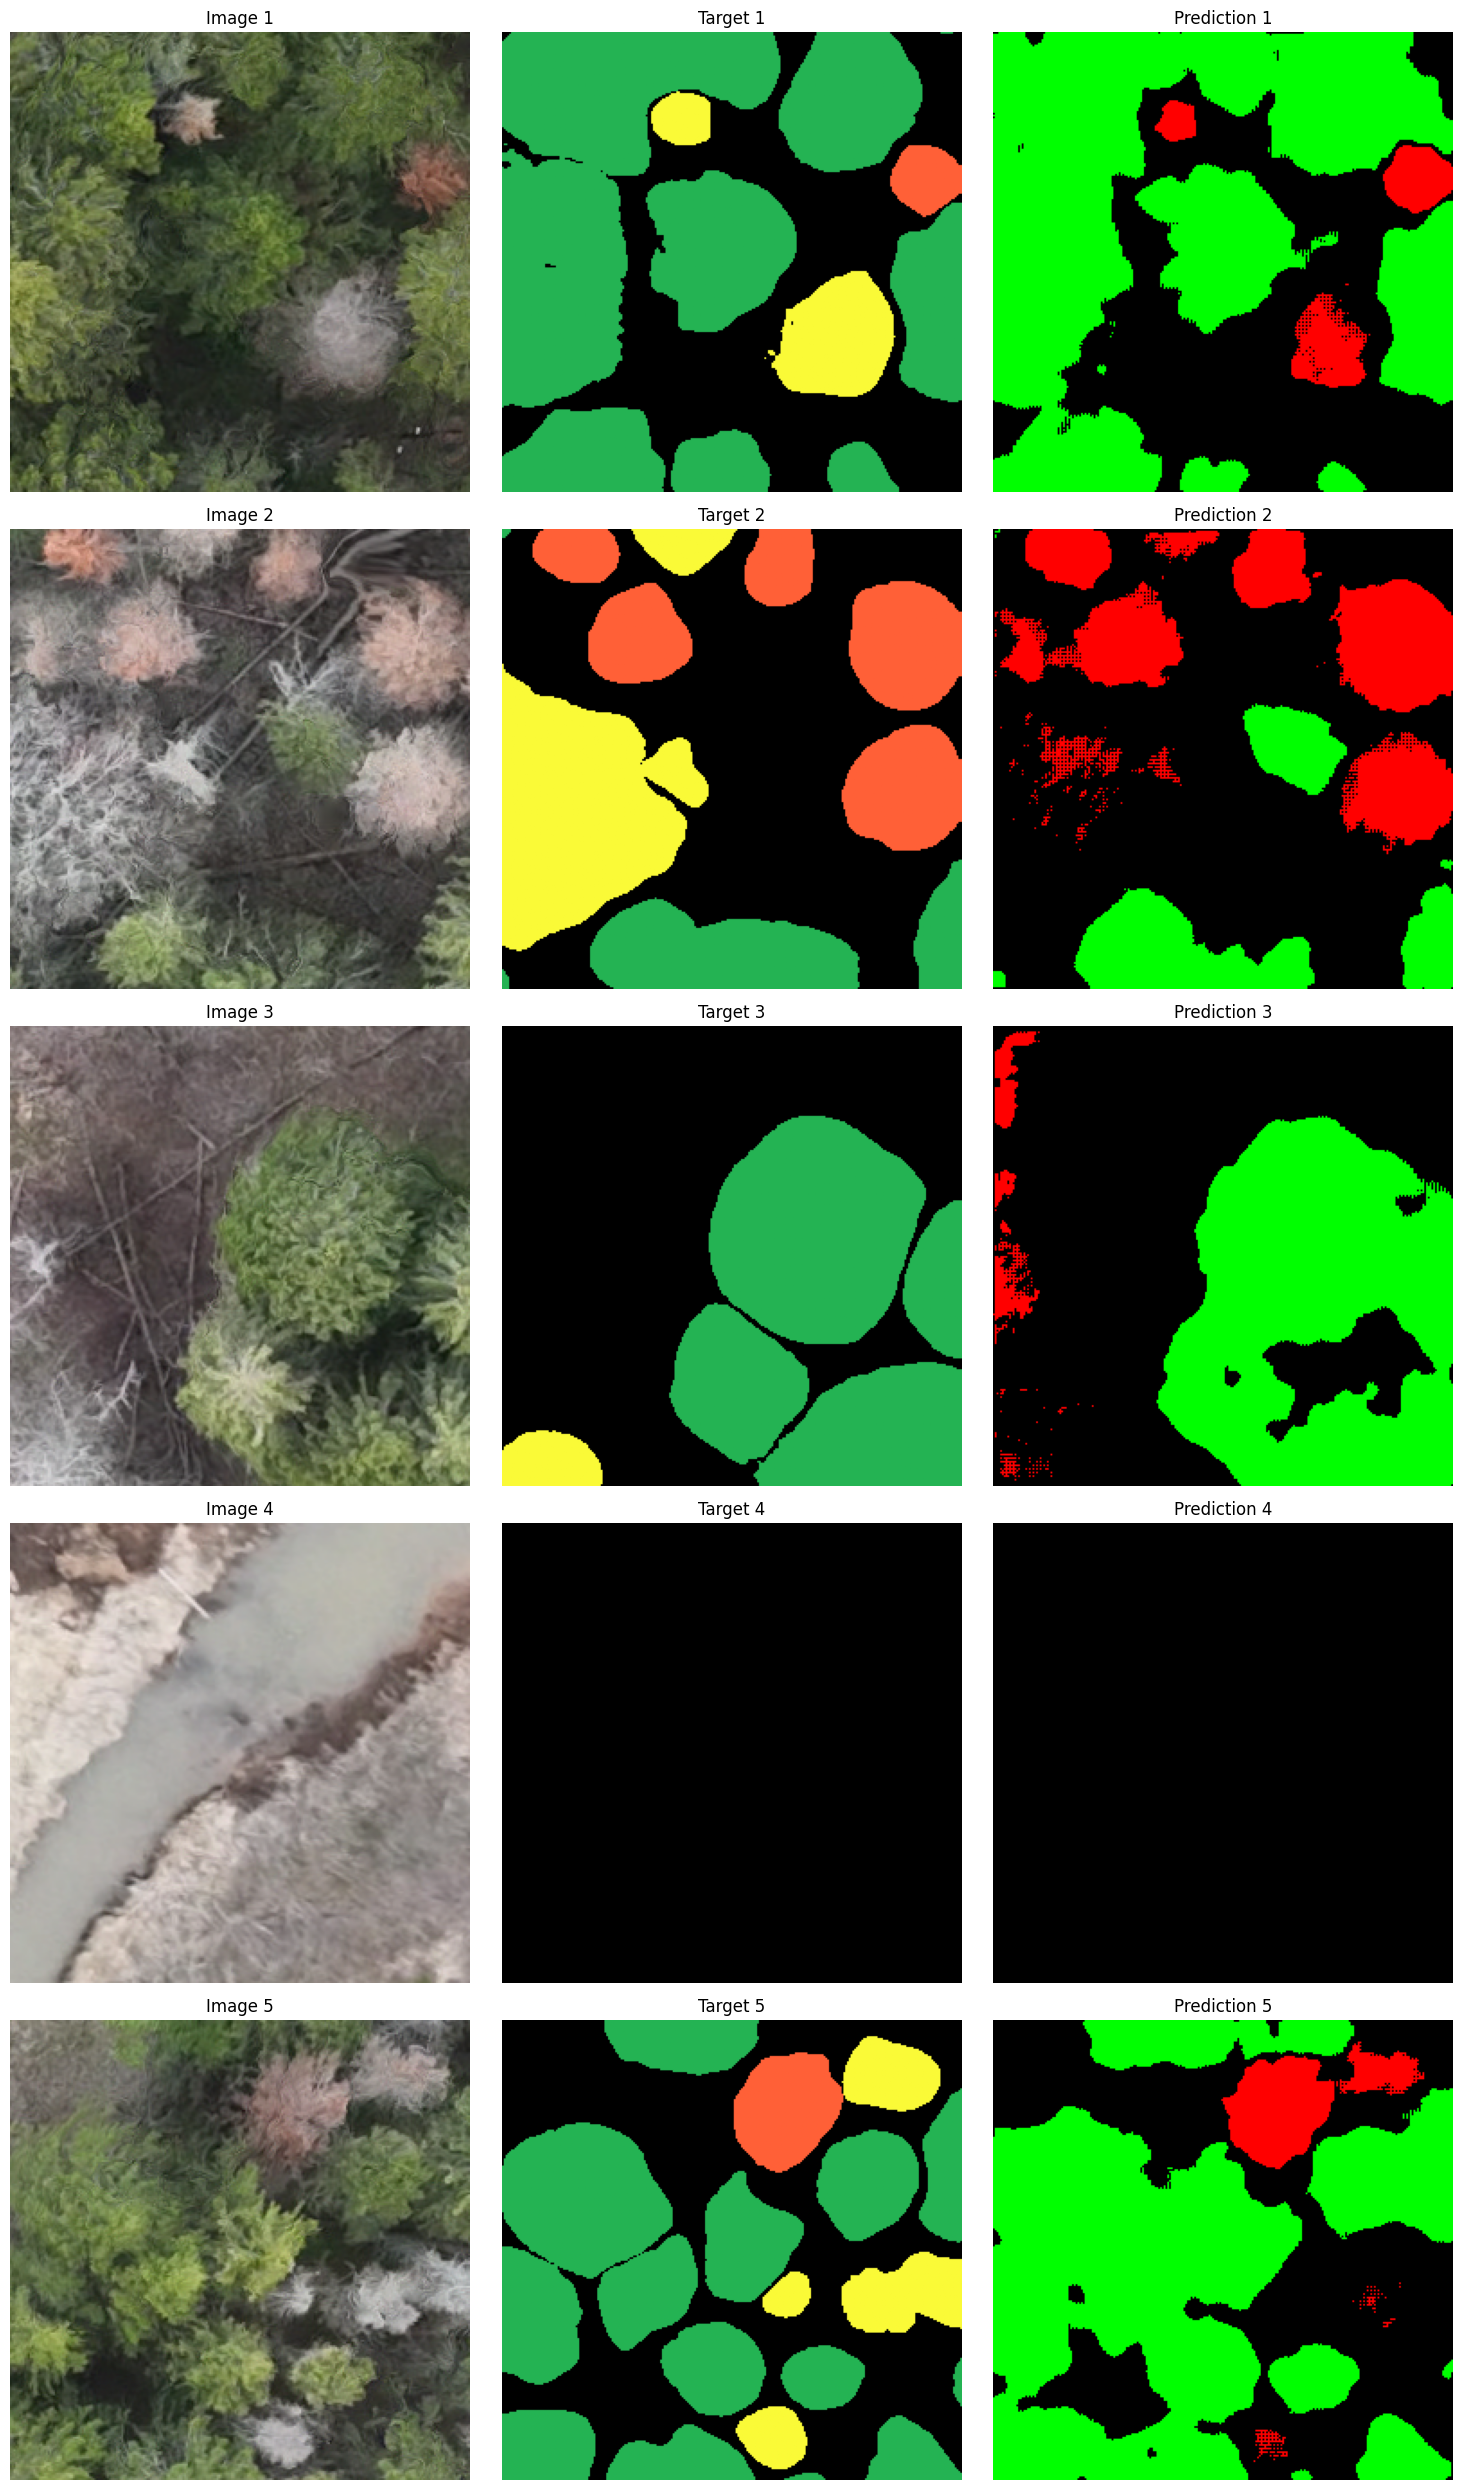

In [15]:
def visualize_segmentation_examples(dataset, model, num_examples=5, device='cpu'):
    model.eval()
    with torch.no_grad():
        plt.figure(figsize=(15, num_examples * 5))
        for i in range(num_examples):

            image, mask = dataset[i]
            image = image.unsqueeze(0).to(device)
            mask = mask.unsqueeze(0).to(device)


            output = model(image)
            pred = (output > 0.5).float()


            image = image.squeeze().cpu().numpy().transpose(1, 2, 0)
            mask = mask.squeeze().cpu().numpy().transpose(1, 2, 0)
            pred = pred.squeeze().cpu().numpy().transpose(1, 2, 0)


            plt.subplot(num_examples, 3, i * 3 + 1)
            plt.imshow(image)
            plt.title(f"Image {i+1}")
            plt.axis("off")

            plt.subplot(num_examples, 3, i * 3 + 2)
            plt.imshow(mask)
            plt.title(f"Target {i+1}")
            plt.axis("off")

            plt.subplot(num_examples, 3, i * 3 + 3)
            plt.imshow(pred)
            plt.title(f"Prediction {i+1}")
            plt.axis("off")

        plt.tight_layout()
        plt.show()


visualize_segmentation_examples(test_dataset, model, num_examples=5, device=device)